# Complute GQMs to Save

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss
from NDNT.utils import subplot_setup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
start    = time.time()
data     = SimCloudData(down_sample=3, num_lags=11, norm_robs=False)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 49.103893518447876 sec


In [3]:
start     = time.time()
test_data = SimCloudData(filename='cloud_TEST_data_stim_dim120_spike_time_sqrad_0.3.hdf5', down_sample=3, num_lags=11, test=True, norm_robs=False)
end       = time.time()
print('CPU Time', end-start, 'sec')

test_robs = test_data.repeat_robs
test_dfs = test_data.repeat_dfs
print(test_robs.shape)
print(test_dfs.shape)

CPU Time 15.246779680252075 sec
(30000, 10, 1491)
(30000, 10, 1491)


In [4]:
# Load baseline LL
GLM_LL = np.load('data/cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.pkl', allow_pickle=True)
GQM_LL = np.load('data/cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.pkl', allow_pickle=True)

In [5]:
cell_idx_dict = data.cell_idx_dict
L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))
mu0s = data.mu0s

In [6]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data.NC
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 40, 40, 1]
num_lags = 11
L = 40
Number of cells 1491
Number of time points 480000


## GQM and GLM

In [7]:
Treg = 1
L1reg = 1.0
Xreg = 10000.0
GLreg = 10.0

glm_par = Tlayer.layer_dict( 
    input_dims=data.stim_dims, num_filters=1, bias=True, num_lags=data.num_lags, norm_type=0,
    NLtype='softplus', initialize_center=True)
glm_par['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10}

In [8]:
Treg = 1
Xreg = 100.0
LOCreg = 10
L1reg = 1.0

# linear layer
glm_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=1, bias=False, norm_type=0, 
    NLtype='lin', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': LOCreg,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# quadratic layer
gqm_layer = Tlayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=2, bias=False, norm_type=0, 
    NLtype='square', initialize_center=True, num_lags=data.num_lags,
    reg_vals= {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': LOCreg,'edge_t':10, 'bcs':{'d2t':1, 'd2x':1}} )

# set up linear and quadratic network
lin_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [glm_layer] )
quad_net =  FFnetwork.ffnet_dict( xstim_n='stim', layer_list = [gqm_layer] )

# NDN layer that combines quadratic and linear layer
comb_layer = NDNLayer.layer_dict( num_filters=1, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

# set up combination network
comb_net = FFnetwork.ffnet_dict( xstim_n=None, ffnet_n=[0,1], layer_list=[comb_layer])

## Test

In [34]:
i = 695
train_ds = GenericDataset( {'stim': data[data.train_blks]['stim'], 
                        'robs': data[data.train_blks]['robs'][:,i], 
                        'dfs':data[data.train_blks]['dfs'][:,i]}, device=device)
test_ds = GenericDataset( {'stim': test_data[:]['stim'], 
                        'robs': test_data[:]['robs'][:,i], 
                        'dfs': test_data[:]['dfs'][:,i]}, device=device)
print(train_ds[:]['stim'].shape)
print(test_ds[:]['stim'].shape)
print(train_ds[:]['robs'].shape)
print(test_ds[:]['robs'].shape)

torch.Size([384000, 1600])
torch.Size([30000, 1600])
torch.Size([384000, 1])
torch.Size([30000, 1])


++INFO: New best!
++INFO: Reg val: 0.01
++INFO: R2 val: tensor([0.5296])


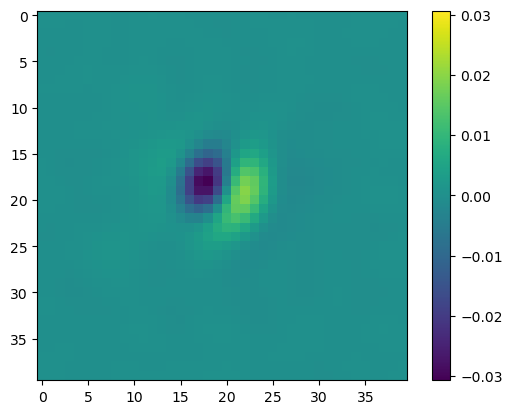

++INFO: New best!
++INFO: Reg val: 0.1
++INFO: R2 val: tensor([0.5297])


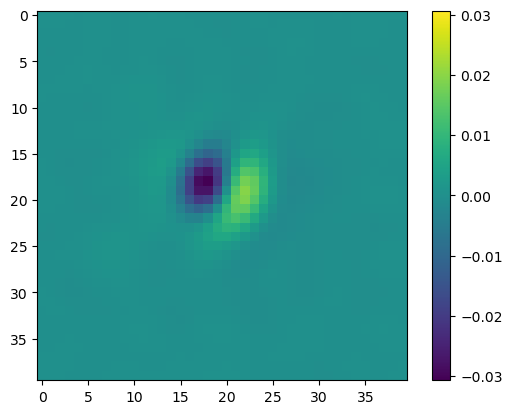

++INFO: Reg val: 1
++INFO: R2 val: tensor([0.5296])


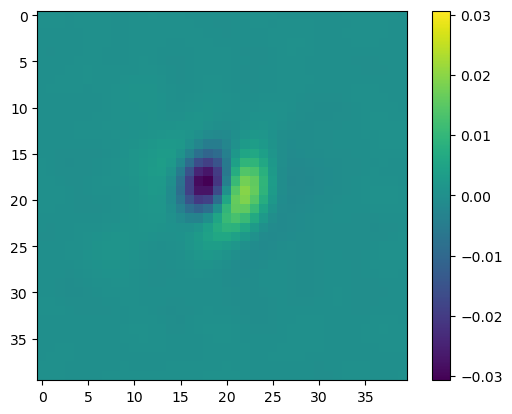

++INFO: Reg val: 10
++INFO: R2 val: tensor([0.5294])


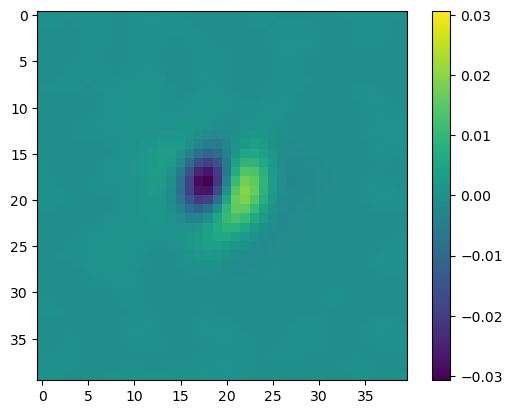

++INFO: Reg val: 100
++INFO: R2 val: tensor([0.5274])


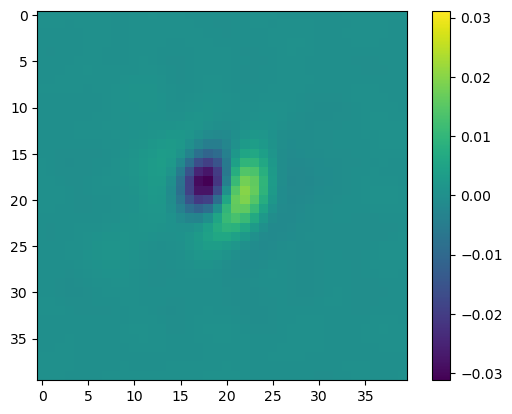

++INFO: Reg val: 1000
++INFO: R2 val: tensor([0.5096])


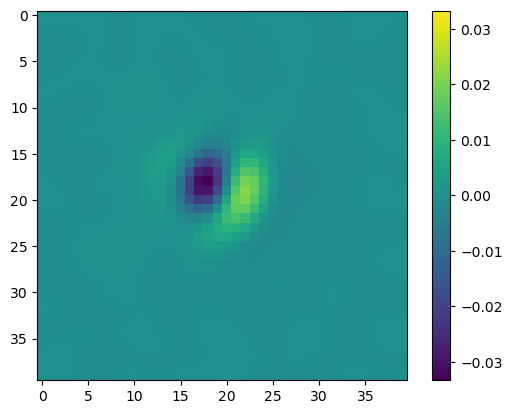

In [35]:
rvals = [0.01, 0.1, 1, 10, 100, 1000]
rvalsG = [0.1, 1, 10, 100, 1000]

XregL = None
XregQ = None
GLregL = None
GLregQ = None

# Initial GLM model
glm_init = NDN( layer_list=[glm_par], loss_type='poisson', seed=100)
glm_init = glm_init.to(device)
fit_lbfgs(glm_init, train_ds[:], verbose=False)
glm_init = glm_init.to(device0)

# Linear d2xt reg val
dest_R2 = -float('inf')
for rr in range(len(rvals)):
    glm = deepcopy(glm_init)
    glm.networks[0].layers[0].weight.data = glm.networks[0].layers[0].weight.data * 0.9
    glm.networks[0].layers[0].reg.vals['d2xt'] = rvals[rr]
    
    glm = glm.to(device)
    fit_lbfgs(glm, train_ds[:], verbose=False)
    glm_pred = glm(test_ds[:]).detach().cpu().numpy()
    glm = glm.to(device0)
    R2_rr = Rsquared_dataset(test_ds, glm_pred, device=device)
    glm = glm.to(device0)

    if (rr == 0) or (R2_rr > best_R2):
        best_R2 = R2_rr
        XregL = rvals[rr]
        best_glm = deepcopy(glm)
        print('++INFO: New best!')
    print('++INFO: Reg val:', rvals[rr])
    print('++INFO: R2 val:', R2_rr)
    
    weights = glm.get_weights()
    imagesc(weights[:,:,-2,0], balanced=True)
    plt.colorbar()
    plt.show()
    
glm_init = deepcopy(best_glm)

++INFO: New best!
++INFO: Reg val: 0.1
++INFO: R2 val: tensor([0.5394])


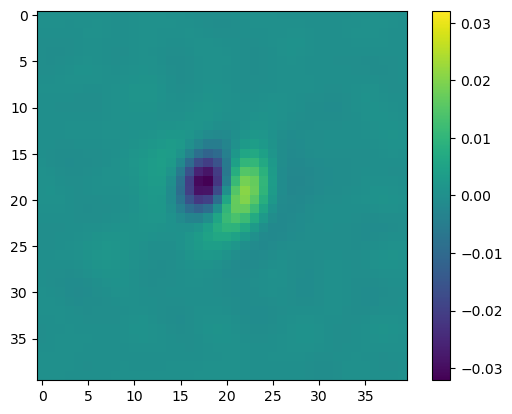

++INFO: Reg val: 1
++INFO: R2 val: tensor([0.5384])


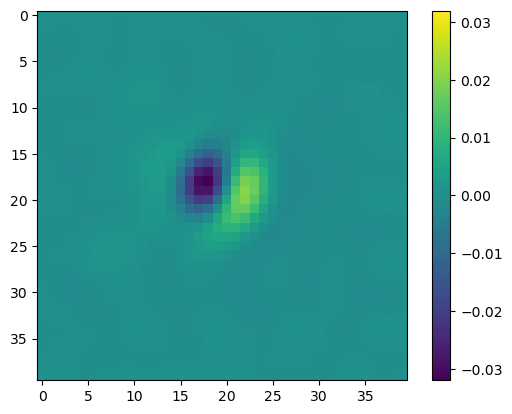

++INFO: Reg val: 10
++INFO: R2 val: tensor([0.5297])


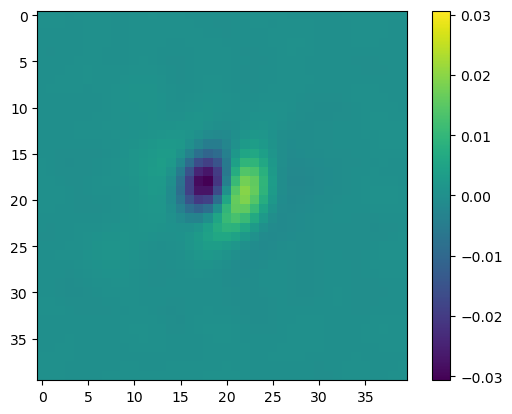

++INFO: Reg val: 100
++INFO: R2 val: tensor([0.4821])


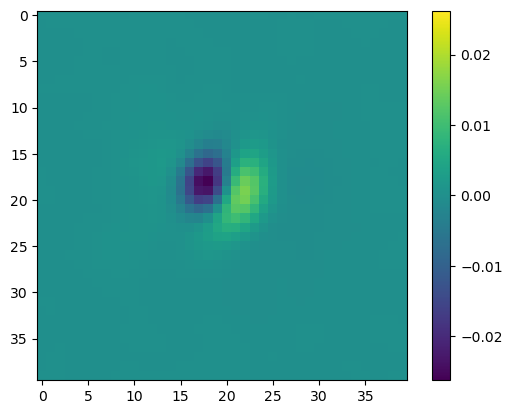

++INFO: Reg val: 1000
++INFO: R2 val: tensor([0.3723])


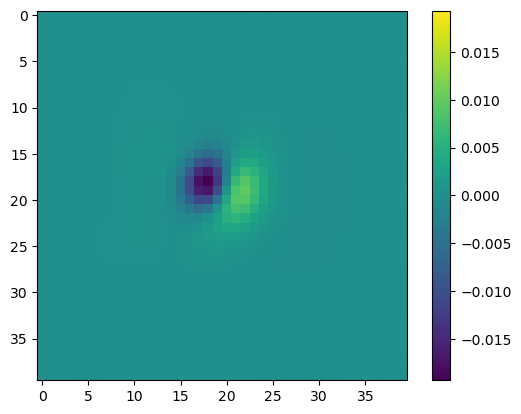

In [36]:
# Linear G-local reg val
dest_R2 = -float('inf')
for rr in range(len(rvalsG)):
    glm = deepcopy(glm_init)
    glm.networks[0].layers[0].weight.data = glm.networks[0].layers[0].weight.data * 0.9
    glm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    glm.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[rr]
    
    glm = glm.to(device)
    fit_lbfgs(glm, train_ds[:], verbose=False)
    glm_pred = glm(test_ds[:]).detach().cpu().numpy()
    R2_rr = Rsquared_dataset(test_ds, glm_pred, device=device)
    glm = glm.to(device0)

    if (rr == 0) or (R2_rr > best_R2):
        best_R2 = R2_rr
        GLregL = rvalsG[rr]
        best_glm = deepcopy(glm)
        print('++INFO: New best!')
    print('++INFO: Reg val:', rvalsG[rr])
    print('++INFO: R2 val:', R2_rr)
    
    weights = glm.get_weights()
    imagesc(weights[:,:,-2,0], balanced=True)
    plt.colorbar()
    plt.show()
    
glm_init = best_glm

++INFO: Newbest!
++INFO: Reg val: 0.01
++INFO: R2 val: tensor([0.6626])


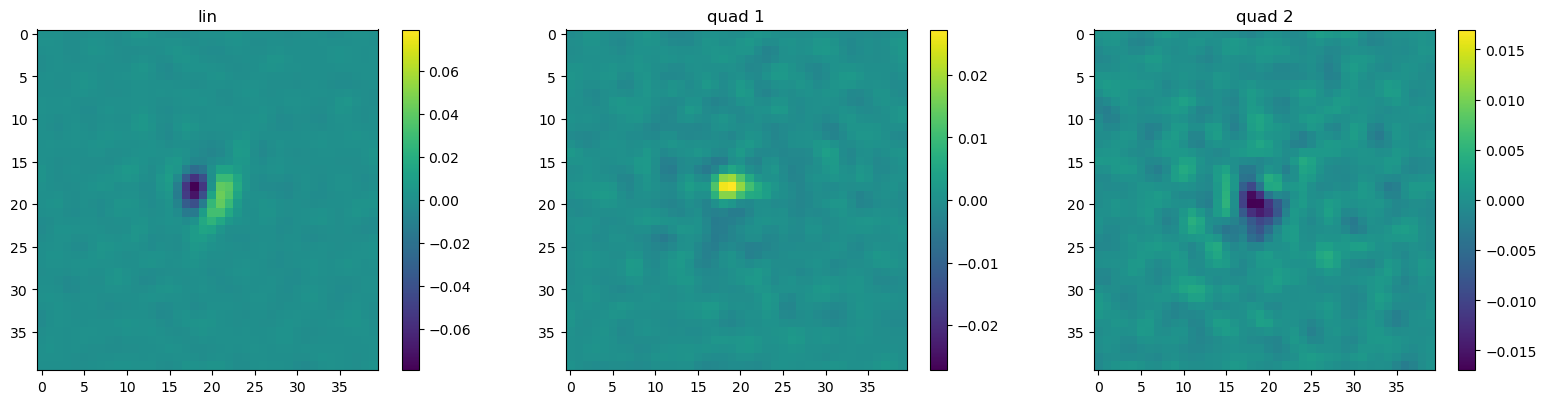

++INFO: Newbest!
++INFO: Reg val: 0.1
++INFO: R2 val: tensor([0.6626])


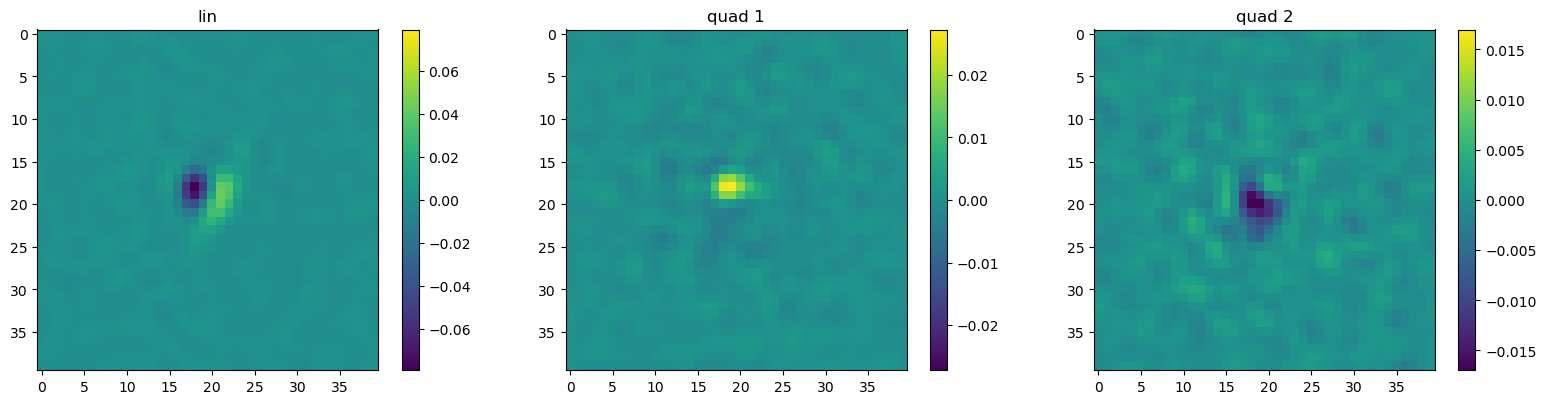

++INFO: Reg val: 1
++INFO: R2 val: tensor([0.6626])


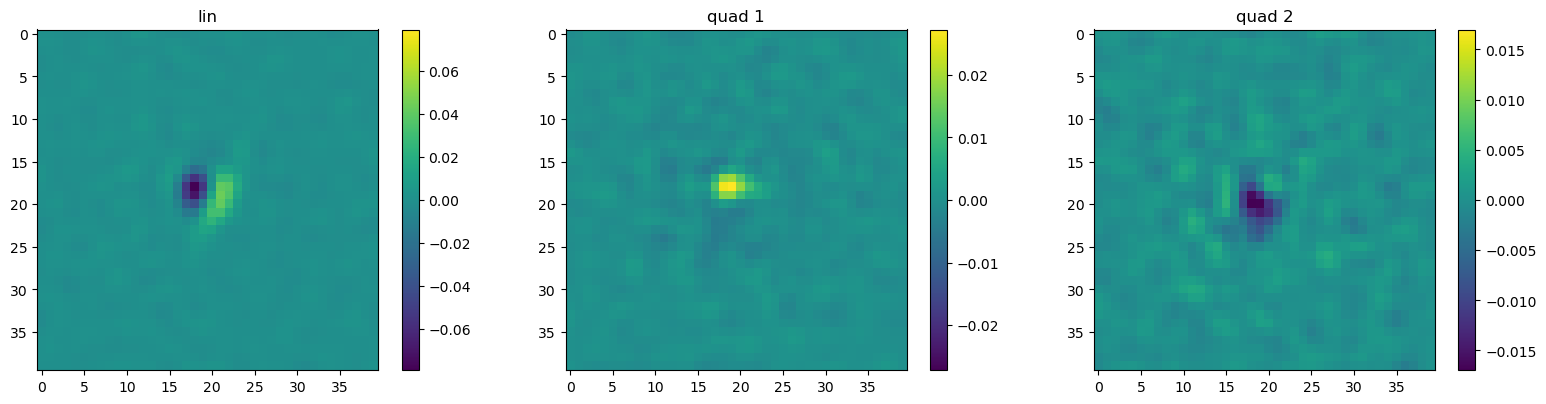

++INFO: Newbest!
++INFO: Reg val: 10
++INFO: R2 val: tensor([0.6626])


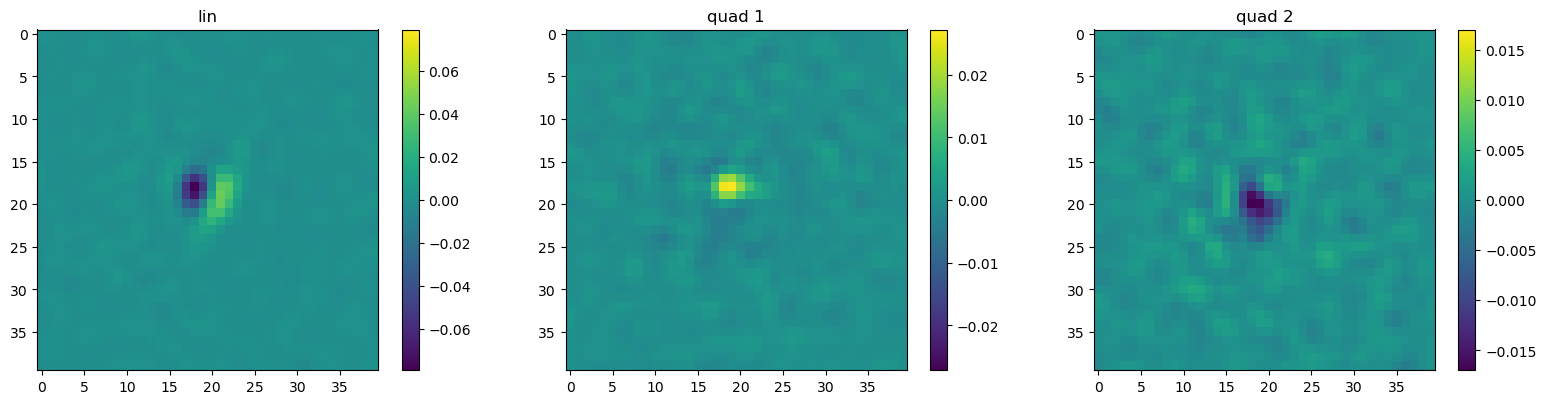

++INFO: Newbest!
++INFO: Reg val: 100
++INFO: R2 val: tensor([0.6627])


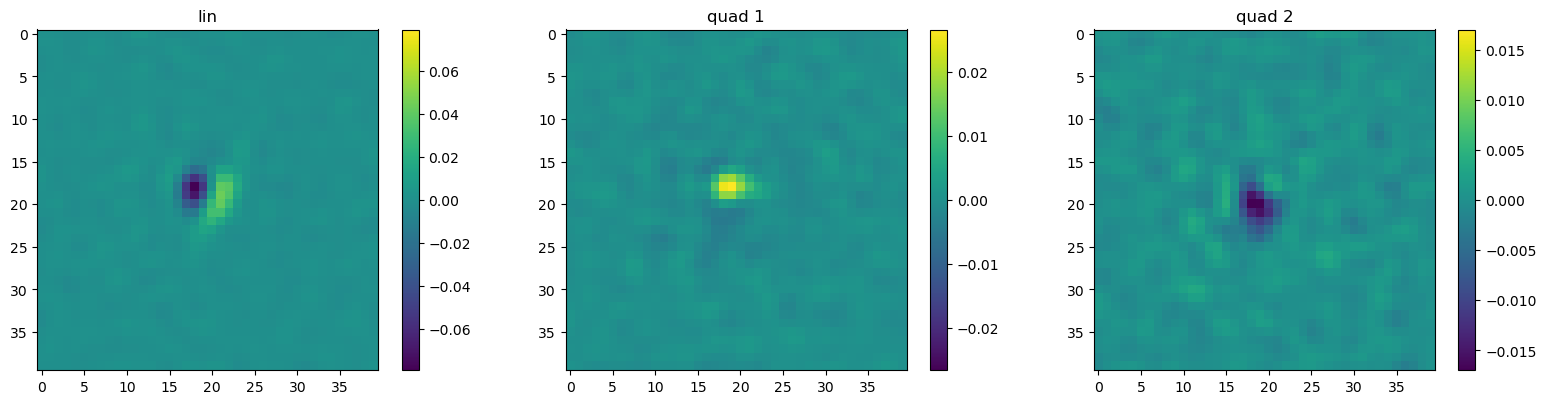

++INFO: Reg val: 1000
++INFO: R2 val: tensor([0.6620])


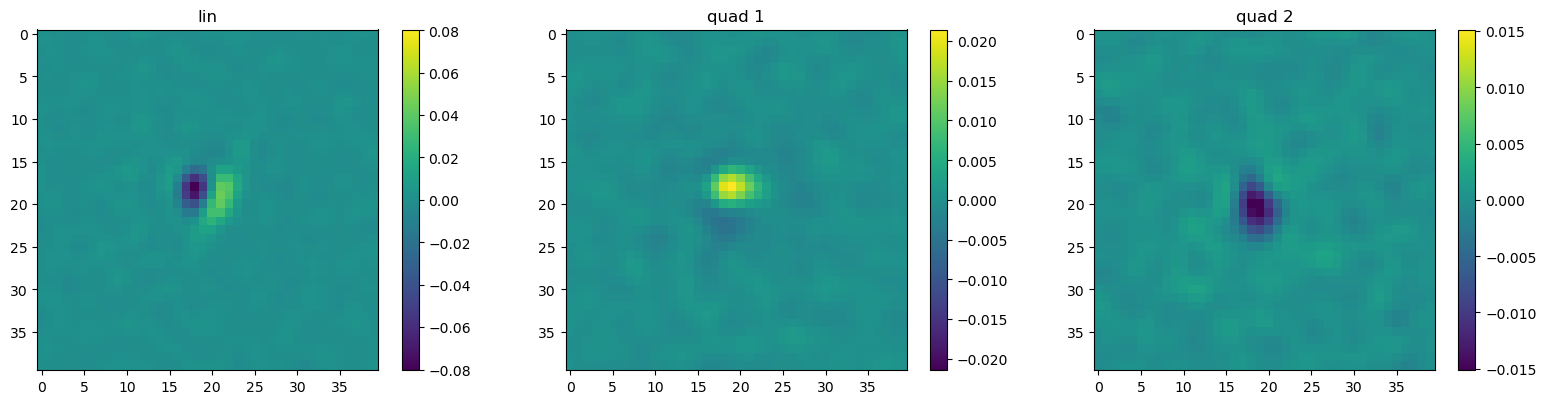

In [37]:
# Initial GQM model
gqm_init = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson', seed=100)
gqm_init.set_parameters(val=False,name='weight',ffnet_target=2)
gqm_init.networks[0].layers[0].weight.data = glm_init.networks[0].layers[0].weight.data
gqm_init.networks[0].layers[0].reg.vals['d2xt'] = XregL
gqm_init.networks[0].layers[0].reg.vals['glocalx'] = GLregL
gqm_init = gqm_init.to(device)
fit_lbfgs(gqm_init, train_ds[:], verbose=False)
gqm_init = gqm_init.to(device0)
    
# Quad d2xt reg val
dest_R2 = -float('inf')
for rr in range(len(rvals)):
    gqm = deepcopy(gqm_init)
    gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    gqm.networks[2].layers[0].bias.data = gqm.networks[2].layers[0].bias.data * 0.9
    gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    gqm.networks[1].layers[0].reg.vals['d2xt'] = rvals[rr]
    
    gqm = gqm.to(device)
    fit_lbfgs(gqm, train_ds[:], verbose=False)
    gqm_pred = gqm(test_ds[:]).detach().cpu().numpy()
    R2_rr = Rsquared_dataset(test_ds, gqm_pred, device=device)
    gqm = gqm.to(device0)
    
    if (rr == 0) or (R2_rr > best_R2):
        best_R2 = R2_rr
        XregQ = rvals[rr]
        best_gqm = deepcopy(gqm)
        print('++INFO: Newbest!')
    print('++INFO: Reg val:', rvals[rr])
    print('++INFO: R2 val:', R2_rr)
    
    lin_weights = gqm.get_weights(ffnet_target=0)
    qu_weights = gqm.get_weights(ffnet_target=1)
    ss(1,3)
    plt.subplot(1,3,1)
    imagesc(lin_weights[:,:,-2,0], balanced=True)
    plt.title('lin')
    plt.colorbar()
    plt.subplot(1,3,2)
    imagesc(qu_weights[:,:,-2,0], balanced=True)
    plt.title('quad 1')
    plt.colorbar()
    plt.subplot(1,3,3)
    imagesc(qu_weights[:,:,-2,1], balanced=True)
    plt.title('quad 2')
    plt.colorbar()
    plt.show()
gqm_init = best_gqm

++INFO: New best!
++INFO: Reg val: 0.1
++INFO: R2 val: tensor([0.6608])


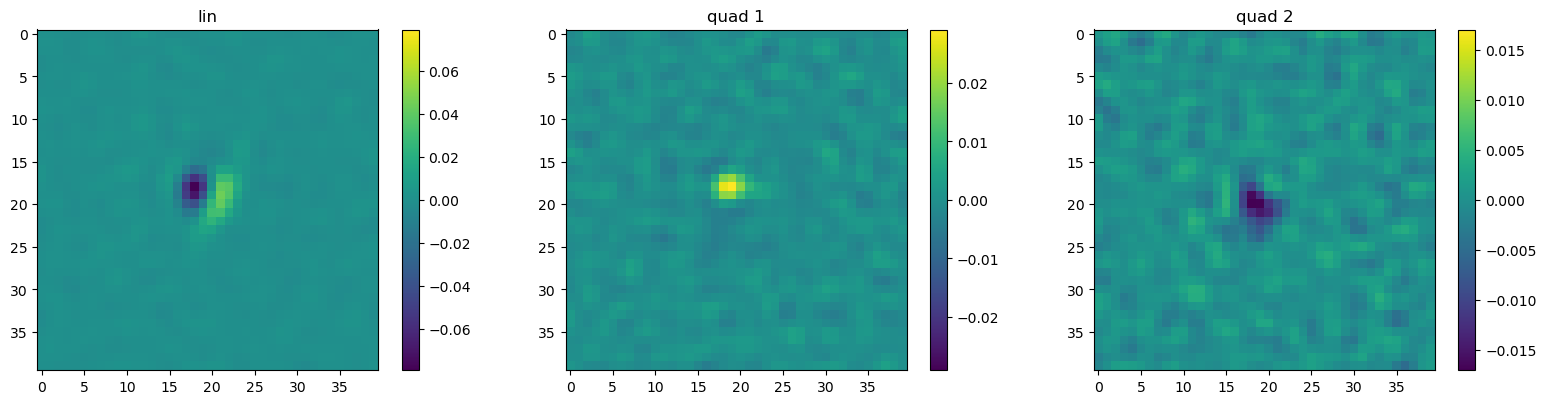

++INFO: New best!
++INFO: Reg val: 1
++INFO: R2 val: tensor([0.6613])


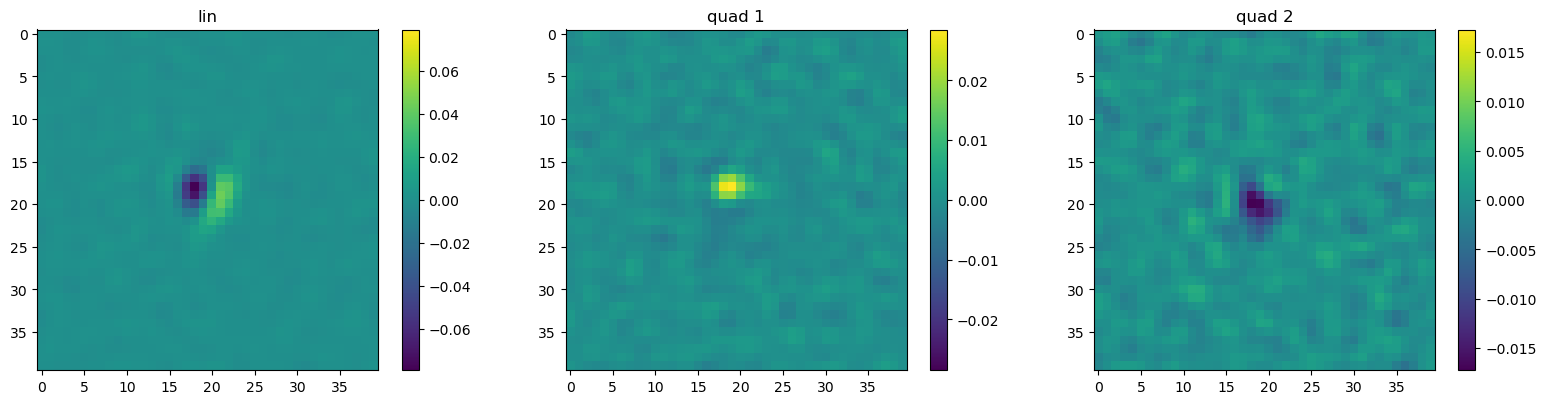

++INFO: New best!
++INFO: Reg val: 10
++INFO: R2 val: tensor([0.6625])


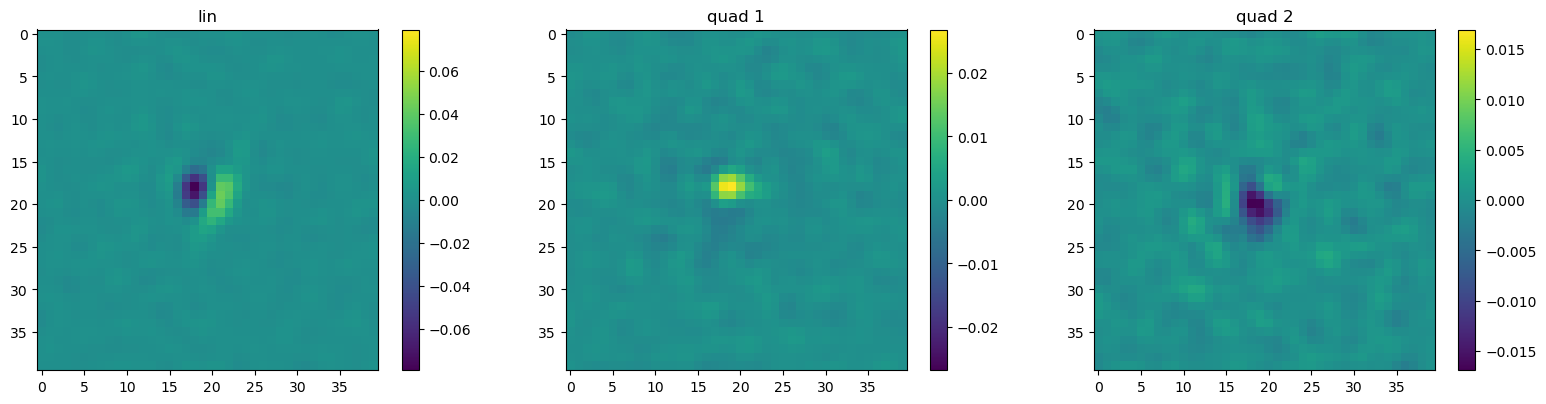

++INFO: New best!
++INFO: Reg val: 100
++INFO: R2 val: tensor([0.6630])


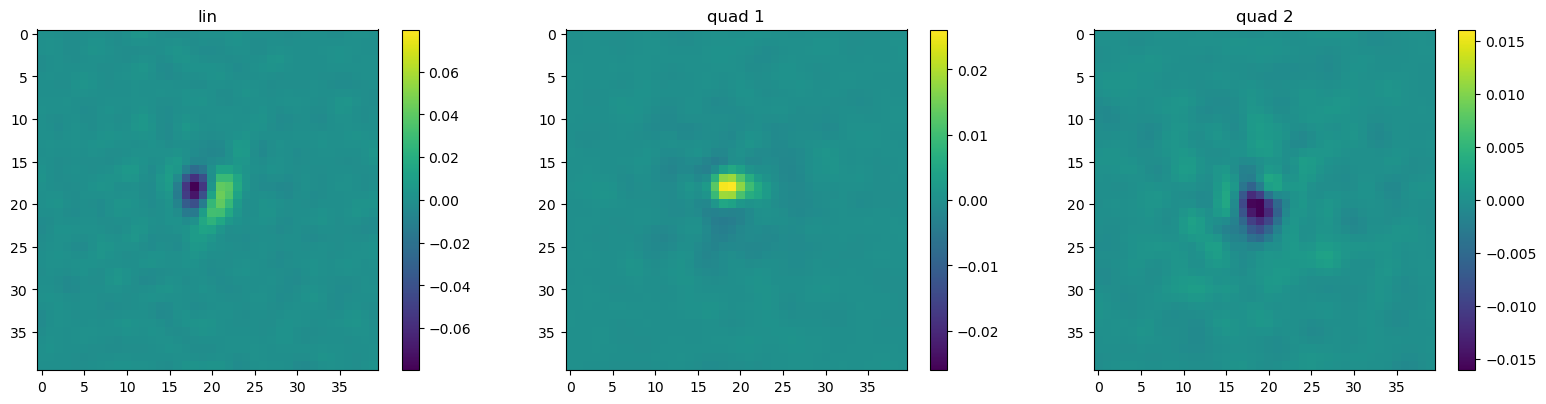

++INFO: New best!
++INFO: Reg val: 1000
++INFO: R2 val: tensor([0.6647])


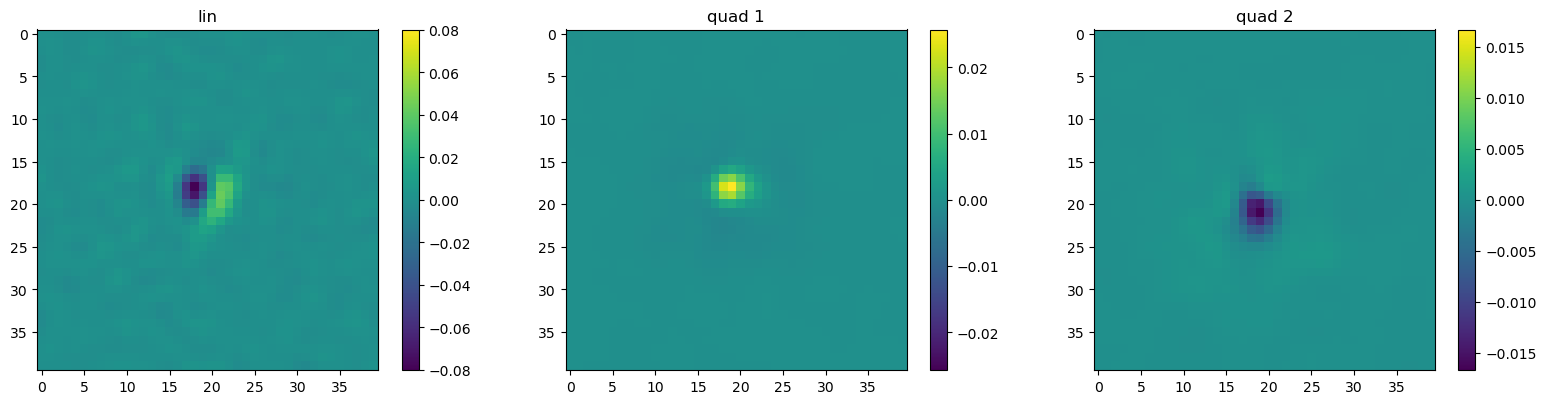

In [38]:
# Quad G-local reg val
dest_R2 = -float('inf')
for rr in range(len(rvalsG)):
    gqm = deepcopy(gqm_init)
    gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    gqm.networks[2].layers[0].bias.data = gqm.networks[2].layers[0].bias.data * 0.9
    gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    gqm.networks[1].layers[0].reg.vals['d2xt'] = XregQ
    gqm.networks[1].layers[0].reg.vals['glocalx'] = rvalsG[rr]
        
    gqm = gqm.to(device)
    fit_lbfgs(gqm, train_ds[:], verbose=False)
    gqm_pred = gqm(test_ds[:]).detach().cpu().numpy()
    R2_rr = Rsquared_dataset(test_ds, gqm_pred, device=device)
    gqm = gqm.to(device0)
    
    if (rr == 0) or (R2_rr > best_R2):
        best_R2 = R2_rr
        GLregQ = rvalsG[rr]
        best_gqm = deepcopy(gqm)
        print('++INFO: New best!')
    print('++INFO: Reg val:', rvalsG[rr])
    print('++INFO: R2 val:', R2_rr)
    
    lin_weights = gqm.get_weights(ffnet_target=0)
    qu_weights = gqm.get_weights(ffnet_target=1)
    ss(1,3)
    plt.subplot(1,3,1)
    imagesc(lin_weights[:,:,-2,0], balanced=True)
    plt.title('lin')
    plt.colorbar()
    plt.subplot(1,3,2)
    imagesc(qu_weights[:,:,-2,0], balanced=True)
    plt.title('quad 1')
    plt.colorbar()
    plt.subplot(1,3,3)
    imagesc(qu_weights[:,:,-2,1], balanced=True)
    plt.title('quad 2')
    plt.colorbar()
    plt.show()
gqm_init = best_gqm

In [39]:
robs = test_ds[:]['robs'].detach().cpu().numpy()
robs.shape

(30000, 1)

In [40]:
best_gqm = best_gqm.to(device)
rpred = best_gqm(test_ds[:]).detach().cpu().numpy()
best_gqm = best_gqm.to(device0)
rpred.shape

(30000, 1)

tensor([0.6647])


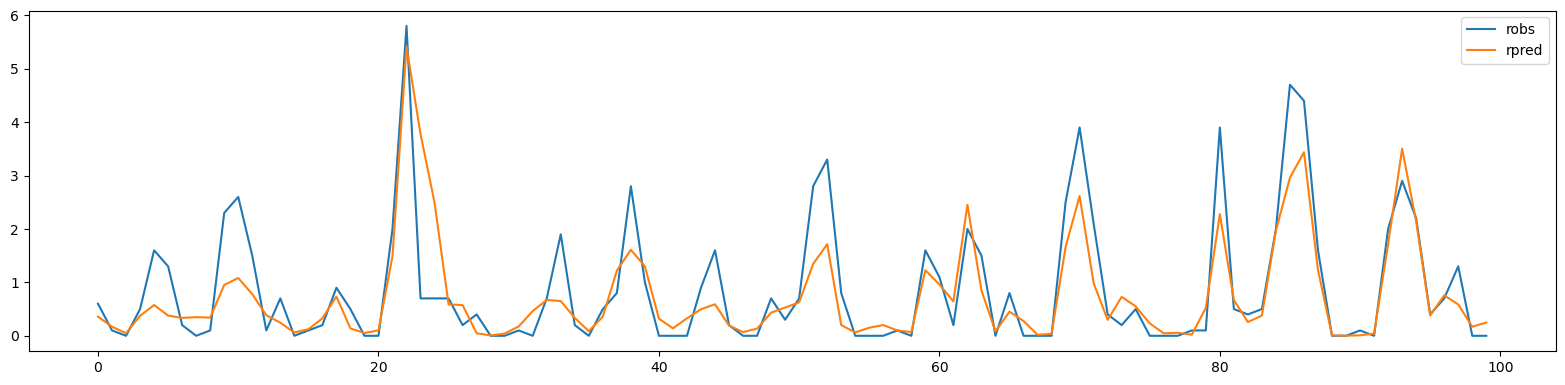

In [41]:
ss()
print(best_R2)
plt.plot(robs[:100,0], label='robs')
plt.plot(rpred[:100,0], label='rpred')
plt.legend()
plt.show()

## Big Loop

In [9]:
batch_size = 100000
gqms = []
glms = []
gqm_LLs = np.zeros(NC)
glm_LLs = np.zeros(NC)
gqm_R2s = np.zeros(NC)
glm_R2s = np.zeros(NC)

rvals = [0.01, 0.1, 1, 10, 100, 1000]
rvalsG = [0.1, 1, 10, 100, 1000]
for i in range(NC):
    start = time.time()
    XregL = None
    XregQ = None
    GLregL = None
    GLregQ = None
    
    gdata_train = GenericDataset( {'stim': data[data.train_blks]['stim'], 
                        'robs': data[data.train_blks]['robs'][:,i], 
                        'dfs':data[data.train_blks]['dfs'][:,i]}, device=device)
    gdata_val = GenericDataset( {'stim': data[data.val_blks]['stim'], 
                        'robs': data[data.val_blks]['robs'][:,i], 
                        'dfs':data[data.val_blks]['dfs'][:,i]}, device=device)
    test_ds = GenericDataset( {'stim': test_data[:]['stim'], 
                        'robs': test_data[:]['robs'][:,i], 
                        'dfs': test_data[:]['dfs'][:,i]}, device=device)

    # Initial GLM model
    glm_init = NDN( layer_list=[glm_par], loss_type='poisson', seed=100)
    glm_init = glm_init.to(device)
    fit_lbfgs(glm_init, gdata_train[:150*data.block_len], verbose=False)
    glm_init = glm_init.to(device0)

    # Linear d2xt reg val
    dest_LL = -float('inf')
    for rr in range(len(rvals)):
        glm = deepcopy(glm_init)
        glm.networks[0].layers[0].weight.data = glm.networks[0].layers[0].weight.data * 0.9
        glm.networks[0].layers[0].reg.vals['d2xt'] = rvals[rr]
    
        glm = glm.to(device)
        fit_lbfgs(glm, gdata_train[:150*data.block_len], verbose=False)
        glm = glm.to(device0)
        LL_rr = glm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]

        if (rr == 0) or (LL_rr > best_LL):
            best_LL = LL_rr
            XregL = rvals[rr]
            best_glm = deepcopy(glm)
    glm_init = best_glm

    # Linear G-local reg val
    dest_LL = -float('inf')
    for rr in range(len(rvalsG)):
        glm = deepcopy(glm_init)
        glm.networks[0].layers[0].weight.data = glm.networks[0].layers[0].weight.data * 0.9
        glm.networks[0].layers[0].reg.vals['d2xt'] = XregL
        glm.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[rr]
    
        glm = glm.to(device)
        fit_lbfgs(glm, gdata_train[:150*data.block_len], verbose=False)
        glm = glm.to(device0)
        LL_rr = glm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]

        if (rr == 0) or (LL_rr > best_LL):
            best_LL = LL_rr
            GLregL = rvalsG[rr]
            best_glm = deepcopy(glm)
    glm_init = best_glm

    # Initial GQM model
    gqm_init = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson', seed=100)
    gqm_init.set_parameters(val=False,name='weight',ffnet_target=2)
    gqm_init.networks[0].layers[0].weight.data = glm_init.networks[0].layers[0].weight.data
    gqm_init.networks[0].layers[0].reg.vals['d2xt'] = XregL
    gqm_init.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    gqm_init = gqm_init.to(device)
    fit_lbfgs(gqm_init, gdata_train[:150*data.block_len], verbose=False)
    gqm_init = gqm_init.to(device0)
    
    # Quad d2xt reg val
    dest_LL = -float('inf')
    for rr in range(len(rvals)):
        gqm = deepcopy(gqm_init)
        gqm.set_parameters(val=False,name='weight',ffnet_target=2)
        #gqm.networks[0].layers[0].weight.data = gqm.networks[0].layers[0].weight.data * 0.6
        #gqm.networks[1].layers[0].weight.data = gqm.networks[1].layers[0].weight.data * 0.7
        gqm.networks[2].layers[0].bias.data = gqm.networks[2].layers[0].bias.data * 0.99
        gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
        gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
        gqm.networks[1].layers[0].reg.vals['d2xt'] = rvals[rr]
    
        gqm = gqm.to(device)
        fit_lbfgs(gqm, gdata_train[:150*data.block_len], verbose=False)
        gqm = gqm.to(device0)
        LL_rr = gqm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
    
        if (rr == 0) or (LL_rr > best_LL):
            best_LL = LL_rr
            XregQ = rvals[rr]
            best_gqm = deepcopy(gqm)
    gqm_init = best_gqm

    # Quad G-local reg val
    dest_LL = -float('inf')
    for rr in range(len(rvalsG)):
        gqm = deepcopy(gqm_init)
        gqm.set_parameters(val=False,name='weight',ffnet_target=2)
        #gqm.networks[0].layers[0].weight.data = gqm.networks[0].layers[0].weight.data * 0.6
        #gqm.networks[1].layers[0].weight.data = gqm.networks[1].layers[0].weight.data * 0.7
        gqm.networks[2].layers[0].bias.data = gqm.networks[2].layers[0].bias.data * 0.99
        gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
        gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
        gqm.networks[1].layers[0].reg.vals['d2xt'] = XregQ
        gqm.networks[1].layers[0].reg.vals['glocalx'] = rvalsG[rr]
        
        gqm = gqm.to(device)
        fit_lbfgs(gqm, gdata_train[:150*data.block_len], verbose=False)
        gqm = gqm.to(device0)
        LL_rr = gqm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
    
        if (rr == 0) or (LL_rr > best_LL):
            best_LL = LL_rr
            GLregQ = rvalsG[rr]
            best_gqm = deepcopy(gqm)
    gqm_init = best_gqm

    # True response
    r = test_robs[:,:,i]
    x = test_dfs[:,:,i]
    
    # run full best GLM
    final_glm = NDN( layer_list=[glm_par], loss_type='poisson')
    final_glm.networks[0].layers[0].weight.data = glm_init.networks[0].layers[0].weight.data
    final_glm.networks[0].layers[0].bias.data = glm_init.networks[0].layers[0].bias.data
    final_glm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    final_glm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    final_glm = best_glm.to(device)
    fit_lbfgs(final_glm, gdata_train[:], verbose=False)
    glm_pred = final_glm(test_ds[:]).detach().cpu().numpy()
    final_glm = final_glm.to(device0)
    best_glm_LL = final_glm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
    best_glm_R2 = comp_test_R2(r, x, glm_pred[:,0])

    # run full best GQM
    final_gqm = NDN( ffnet_list = [lin_net, quad_net, comb_net], loss_type='poisson')
    final_gqm.set_parameters(val=False,name='weight',ffnet_target=2)
    final_gqm.networks[0].layers[0].weight.data = gqm_init.networks[0].layers[0].weight.data
    final_gqm.networks[1].layers[0].weight.data = gqm_init.networks[1].layers[0].weight.data
    final_gqm.networks[2].layers[0].bias.data = gqm_init.networks[2].layers[0].bias.data
    final_gqm.networks[0].layers[0].reg.vals['d2xt'] = XregL
    final_gqm.networks[0].layers[0].reg.vals['glocalx'] = GLregL
    final_gqm.networks[1].layers[0].reg.vals['d2xt'] = XregQ
    final_gqm.networks[1].layers[0].reg.vals['glocalx'] = GLregQ
    final_gqm = final_gqm.to(device)
    fit_lbfgs(final_gqm, gdata_train[:], verbose=False)
    gqm_pred = final_gqm(test_ds[:]).detach().cpu().numpy()
    final_gqm = final_gqm.to(device0)
    best_gqm_LL = final_gqm.eval_models(gdata_val[:], device=device, batch_size=batch_size, null_adjusted=True)[0]
    best_gqm_R2 = comp_test_R2(r, x, gqm_pred[:,0])
    
    gqms.append(final_gqm)
    glms.append(final_glm)
    gqm_LLs[i] = best_gqm_LL
    glm_LLs[i] = best_glm_LL
    gqm_R2s[i] = best_gqm_R2
    glm_R2s[i] = best_glm_R2
    end = time.time()
    print('Cell', i, 'complete', end-start, 'sec')

    gdata_train = None
    gdata_val = None

Cell 0 complete 144.51311659812927 sec
Cell 1 complete 182.4882447719574 sec
Cell 2 complete 127.70218205451965 sec
Cell 3 complete 148.58914041519165 sec
Cell 4 complete 139.1027591228485 sec
Cell 5 complete 161.84703373908997 sec
Cell 6 complete 126.8879132270813 sec
Cell 7 complete 216.78192234039307 sec
Cell 8 complete 147.1366946697235 sec
Cell 9 complete 146.79544591903687 sec
Cell 10 complete 136.1459925174713 sec
Cell 11 complete 155.94869685173035 sec
Cell 12 complete 177.04455494880676 sec
Cell 13 complete 127.41065669059753 sec
Cell 14 complete 182.72683095932007 sec
Cell 15 complete 141.62540245056152 sec
Cell 16 complete 144.45532250404358 sec
Cell 17 complete 160.38573217391968 sec
Cell 18 complete 150.79870915412903 sec
Cell 19 complete 139.25899815559387 sec
Cell 20 complete 140.04177498817444 sec
Cell 21 complete 185.444509267807 sec
Cell 22 complete 139.3919177055359 sec
Cell 23 complete 180.73102045059204 sec
Cell 24 complete 142.88746070861816 sec
Cell 25 complete 1

In [10]:
np.save('data/cloud_test_data_stim_dim_120_sqrad_0.3_GQM_R2.npy',gqm_R2s)
np.save('data/cloud_test_data_stim_dim_120_sqrad_0.3_GLM_R2.npy',glm_R2s)

In [13]:
print('GLM R2 mean', np.mean(glm_R2s))
print('L4 Exc Mean R2:', np.mean(glm_R2s[L4_exc_idx]), '+/-', np.std(glm_R2s[L4_exc_idx]))
print('L4 Inh Mean R2:', np.mean(glm_R2s[L4_inh_idx]), '+/-', np.std(glm_R2s[L4_inh_idx]))
print('L2/3 Exc Mean R2:', np.mean(glm_R2s[L23_exc_idx]), '+/-', np.std(glm_R2s[L23_exc_idx]))
print('L2/3 Inh Mean R2:', np.mean(glm_R2s[L23_inh_idx]), '+/-', np.std(glm_R2s[L23_inh_idx]))

GLM R2 mean 0.18228672090336234
L4 Exc Mean R2: 0.2317760857559399 +/- 0.1259510780721225
L4 Inh Mean R2: 0.36661232357766005 +/- 0.09638216564880876
L2/3 Exc Mean R2: 0.08887111071186161 +/- 0.06116363839538588
L2/3 Inh Mean R2: 0.09258560539005775 +/- 0.05304442912578069


In [14]:
print('GLM R2 mean', np.mean(gqm_R2s))
print('L4 Exc Mean R2:', np.mean(gqm_R2s[L4_exc_idx]), '+/-', np.std(gqm_R2s[L4_exc_idx]))
print('L4 Inh Mean R2:', np.mean(gqm_R2s[L4_inh_idx]), '+/-', np.std(gqm_R2s[L4_inh_idx]))
print('L2/3 Exc Mean R2:', np.mean(gqm_R2s[L23_exc_idx]), '+/-', np.std(gqm_R2s[L23_exc_idx]))
print('L2/3 Inh Mean R2:', np.mean(gqm_R2s[L23_inh_idx]), '+/-', np.std(gqm_R2s[L23_inh_idx]))

GLM R2 mean 0.3376971946807444
L4 Exc Mean R2: 0.3685925212957125 +/- 0.13784344851526584
L4 Inh Mean R2: 0.538328692675094 +/- 0.07979148002738586
L2/3 Exc Mean R2: 0.2519076670251512 +/- 0.05230027031603791
L2/3 Inh Mean R2: 0.2736591941592221 +/- 0.04471695875111277


In [9]:
print('Done')

Done


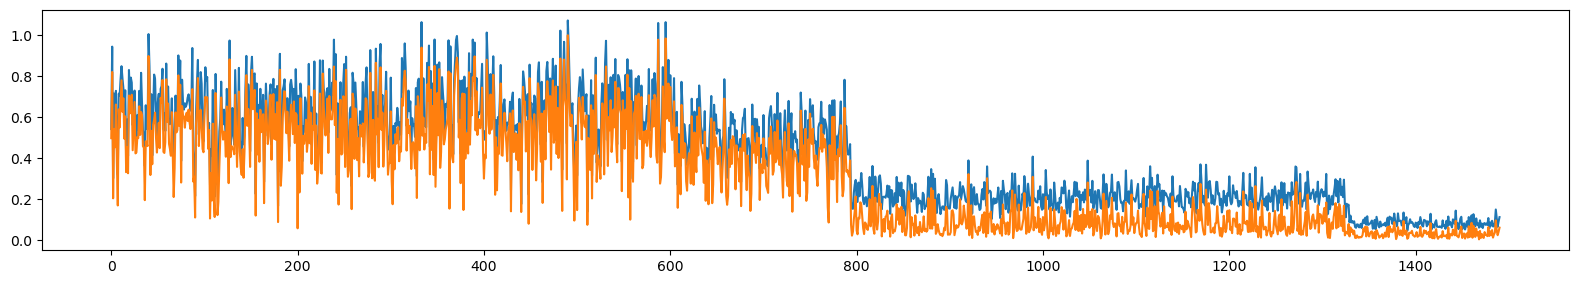

In [13]:
ss()
plt.plot(gqm_LLs)
plt.plot(glm_LLs)

In [14]:
all_gqm_weights = np.zeros((NC,L,L,num_lags,3))
for i in range(NC):
    all_gqm_weights[i,:,:,:,0] = gqms[i].get_weights(ffnet_target=0)[:,:,:,0] # lin weights
    all_gqm_weights[i,:,:,:,1] = gqms[i].get_weights(ffnet_target=1)[:,:,:,0] # quad 1 weights
    all_gqm_weights[i,:,:,:,2] = gqms[i].get_weights(ffnet_target=1)[:,:,:,1] # quad 2 weights
print(all_gqm_weights.shape)

(1491, 60, 60, 11, 3)


In [15]:
import pickle
with open('data/2-28_update_all_neuron_GQM_weights_sqrad_0.3_.pkl', 'wb') as f:
    pickle.dump(all_gqm_weights, f)

In [31]:
all_glm_weights = np.zeros((NC,L,L,num_lags))
for i in range(NC):
    all_glm_weights[i,:,:,:] = gqms[i].get_weights(ffnet_target=0)[:,:,:,0] # lin weights
print(all_glm_weights.shape)

(1491, 60, 60, 11)


In [32]:
import pickle
with open('data/2-28_update_all_neuron_GLM_weights_sqrad_0.3_.pkl', 'wb') as f:
    pickle.dump(all_glm_weights, f)

## Weights

In [26]:
cell = 1400
lin = gqms[cell].get_weights(ffnet_target=0)[:,:,:,0] # lin weights
quad1 = gqms[cell].get_weights(ffnet_target=1)[:,:,:,0] # quad 1 weights
quad2 = gqms[cell].get_weights(ffnet_target=1)[:,:,:,1] # quad 2 weights

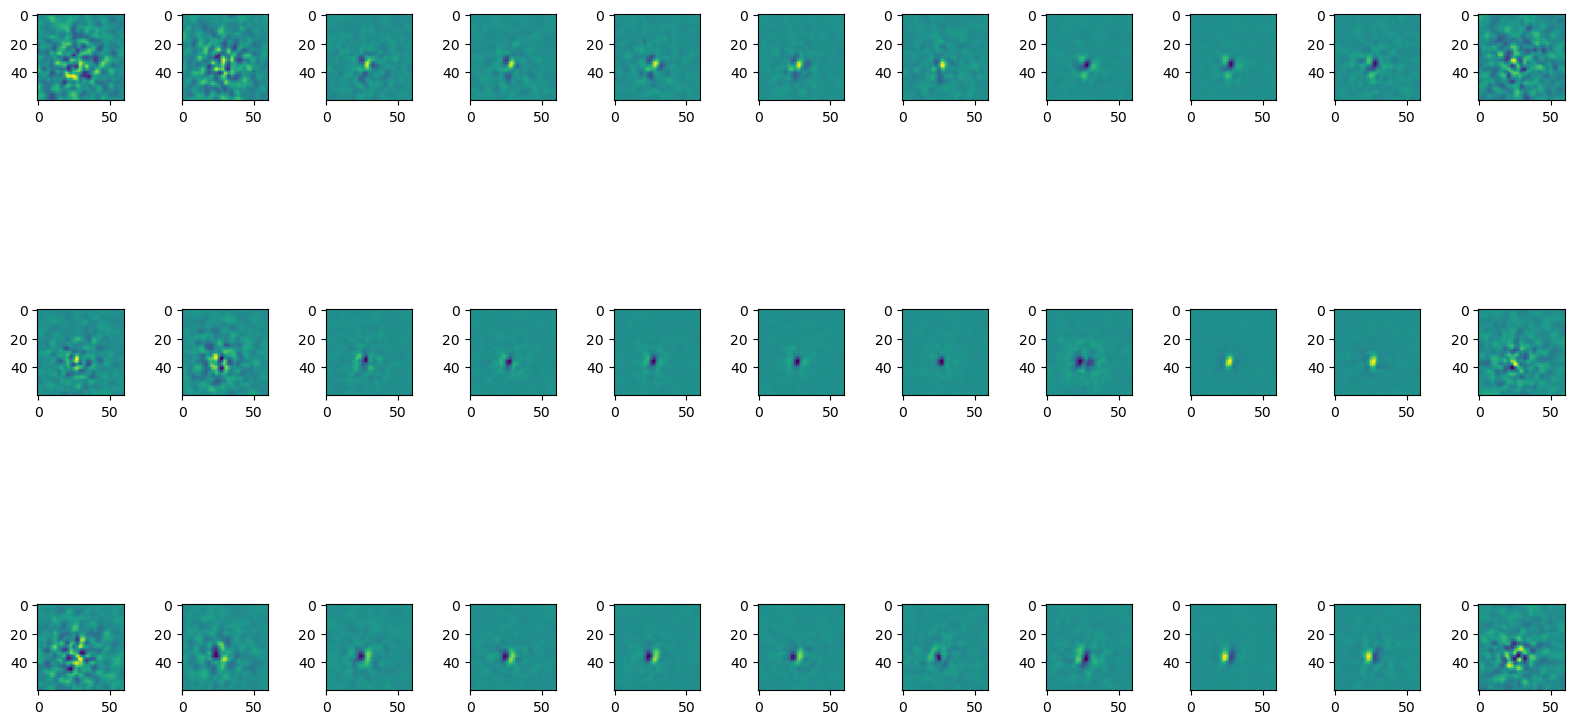

In [27]:
ss(3,11)
k = 1
for i in range(11):
    plt.subplot(3,11,k)
    imagesc(lin[:,:,i], balanced=True)
    k += 1
for i in range(11):
    plt.subplot(3,11,k)
    imagesc(quad1[:,:,i], balanced=True)
    k += 1
for i in range(11):
    plt.subplot(3,11,k)
    imagesc(quad2[:,:,i], balanced=True)
    k += 1
plt.show()

## Complexity

In [28]:
complexity = np.zeros(NC)
for i in range(NC):
    gdata = GenericDataset( {'stim': data[data.val_blks]['stim'], 
                         'robs': data[data.val_blks]['robs'][:,i], 
                         'dfs':data[data.val_blks]['dfs'][:,i]}, device=device)

    gqm = gqms[i].to(device)
    lin_pred = gqm.networks[0](gdata[:]['stim']).detach().cpu().numpy()[:,0]
    quad_pred = np.sum(gqm.networks[1](gdata[:]['stim']).detach().cpu().numpy(),axis=1) # + gqm[i].networks[2](gdata[:]['stim']).detach().cpu().numpy()
    gqm = gqm.to(device0)

    lin_var = np.var(lin_pred)
    quad_var = np.var(quad_pred)
    complexity[i] = lin_var/(lin_var+quad_var)

    print('Cell', i, 'complexity computed')
    gdata = None

Cell 0 complexity computed
Cell 1 complexity computed
Cell 2 complexity computed
Cell 3 complexity computed
Cell 4 complexity computed
Cell 5 complexity computed
Cell 6 complexity computed
Cell 7 complexity computed
Cell 8 complexity computed
Cell 9 complexity computed
Cell 10 complexity computed
Cell 11 complexity computed
Cell 12 complexity computed
Cell 13 complexity computed
Cell 14 complexity computed
Cell 15 complexity computed
Cell 16 complexity computed
Cell 17 complexity computed
Cell 18 complexity computed
Cell 19 complexity computed
Cell 20 complexity computed
Cell 21 complexity computed
Cell 22 complexity computed
Cell 23 complexity computed
Cell 24 complexity computed
Cell 25 complexity computed
Cell 26 complexity computed
Cell 27 complexity computed
Cell 28 complexity computed
Cell 29 complexity computed
Cell 30 complexity computed
Cell 31 complexity computed
Cell 32 complexity computed
Cell 33 complexity computed
Cell 34 complexity computed
Cell 35 complexity computed
Ce

In [29]:
np.save('data/2-28_update_all_neuron_complexity_sqrad_0.3.npy', complexity)

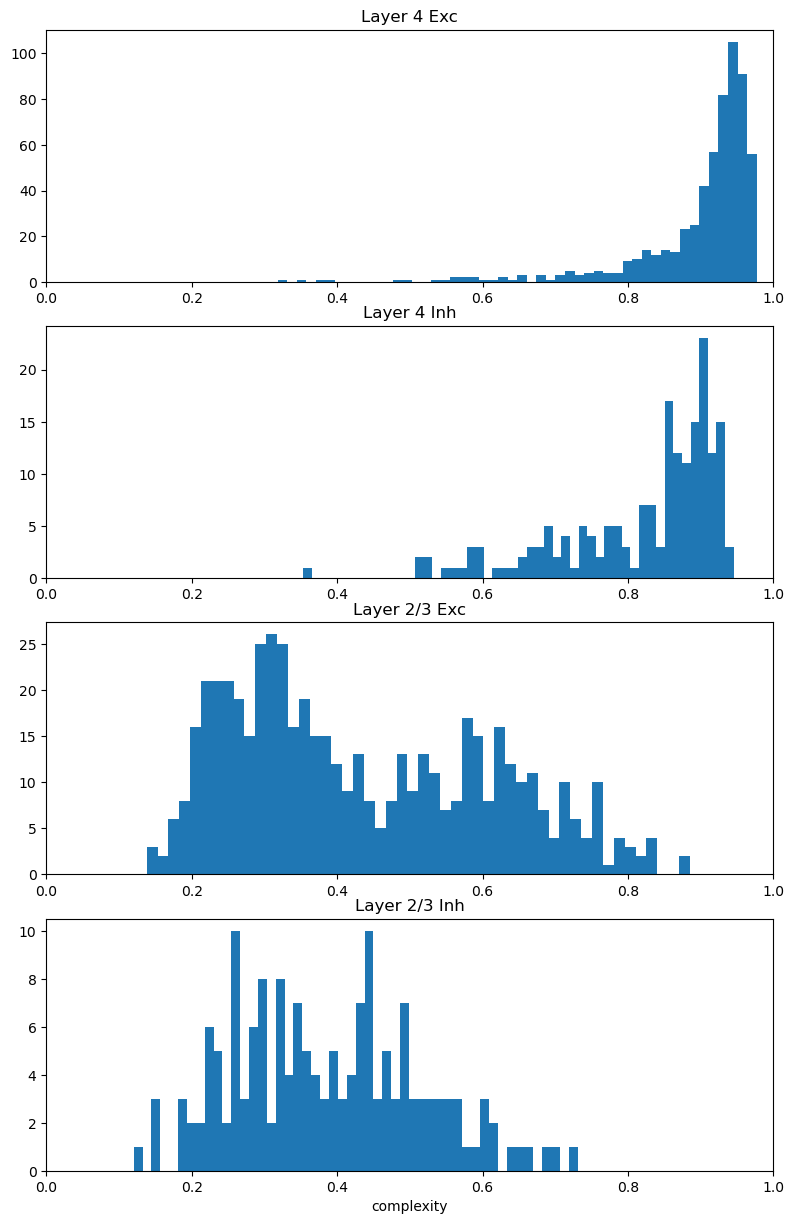

In [39]:
subplot_setup(4, 1, row_height=3, fig_width=8)
plt.subplot(4,1,1)
plt.hist(complexity[L4_exc_idx],50)
plt.title('Layer 4 Exc')
plt.xlim([0,1])

plt.subplot(4,1,2)
plt.hist(complexity[L4_inh_idx],50)
plt.title('Layer 4 Inh')
plt.xlim([0,1])

plt.subplot(4,1,3)
plt.hist(complexity[L23_exc_idx],50)
plt.title('Layer 2/3 Exc')
plt.xlim([0,1])

plt.subplot(4,1,4)
plt.hist(complexity[L23_inh_idx],50)
plt.title('Layer 2/3 Inh')
plt.xlim([0,1])
plt.xlabel('complexity')

plt.show()

## Baseline Log-Likelyhood

In [30]:
np.save('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.npy',gqm_LLs)
np.save('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.npy',glm_LLs)